In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rasterio
import teotil3 as teo
from rasterio.features import geometry_mask
from rasterio.mask import mask

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Estimate harvested area by region using SR16beta

## 1. By Fylke

In [4]:
# Raw data is already chunked by fylke
raw_path = (
    r"/home/jovyan/shared/common/oslofjord_modelling/nibio_skog/data/sr16beta/raw"
)
fylkes = [42, 34, 15, 18, 3, 11, 54, 50, 38, 46, 30]
data_dict = {
    "fylke": [],
    "year": [],
    "harvest_area_km2": [],
}
for fylke in fylkes:
    tif_path = os.path.join(raw_path, f"sr16_{fylke}_SRRHOGSTAARbeta.tif")
    with rasterio.open(tif_path) as src:
        data = src.read(1)

    # Get unique years with data
    years = [int(val) for val in np.unique(data) if (val > 0) and ~np.isnan(val)]
    for year in years:
        area = np.count_nonzero(data == year) * 16 * 16 / 1e6
        data_dict["fylke"].append(fylke)
        data_dict["year"].append(year)
        data_dict["harvest_area_km2"].append(area)

df = pd.DataFrame(data_dict)
df["harvest_area_km2"] = df["harvest_area_km2"].astype(float)
df.dropna(subset="harvest_area_km2", inplace=True)

df.head()

,fylke,year,harvest_area_km2
0,42,2011,0.580608
1,42,2012,1.388288
2,42,2013,2.507008
3,42,2014,1.137920
4,42,2015,2.984704


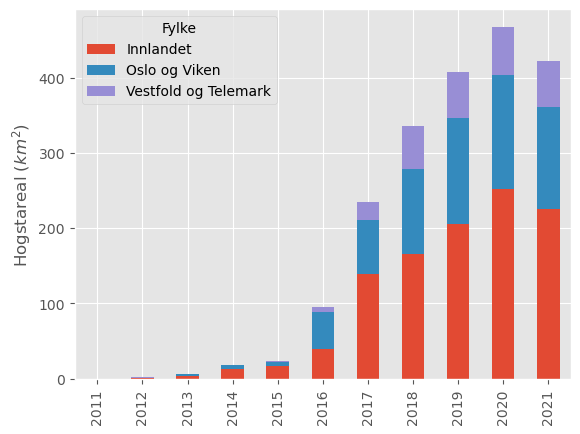

In [5]:
df["Fylke"] = df["fylke"].map(
    {
        3: "Oslo og Viken",
        30: "Oslo og Viken",
        34: "Innlandet",
        38: "Vestfold og Telemark",
    }
)
df2 = (
    df.dropna(subset="Fylke")
    .groupby(["Fylke", "year"])
    .sum(numeric_only=True)
    .reset_index()
)
df_pivot = df2.pivot(index="year", columns="Fylke", values="harvest_area_km2")
df_pivot.plot(kind="bar", stacked=True)
plt.xlabel("")
plt.ylabel("Hogstareal ($km^2$)")
plt.savefig(r"./images/harvest_area_by_fylke.png", dpi=200, bbox_inches="tight")

## 2. For Oslofjord

In [6]:
gdf = teo.io.get_regine_geodataframe(eng, 2021).to_crs("epsg:25832")
cols = ["regine", "geometry"]
gdf = gdf[cols]

vass_min, vass_max = 1, 14
vass_list = [f"{vass:03d}" for vass in range(vass_min, vass_max + 1)]
gdf["vassom"] = gdf["regine"].str.split(".", n=1, expand=True)[0]
gdf = gdf.query("vassom in @vass_list")

gdf["dissolve"] = 1
gdf = gdf.dissolve(by="dissolve").reset_index()
del gdf["vassom"], gdf["dissolve"]

<Axes: >

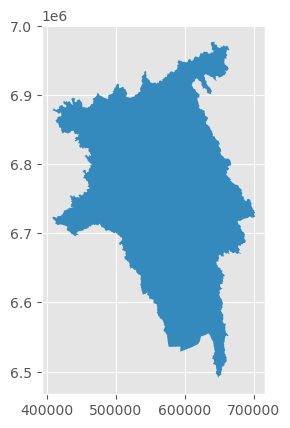

In [7]:
gdf.plot()

In [8]:
tif_path = r"/home/jovyan/shared/common/oslofjord_modelling/nibio_skog/data/sr16beta/sr16beta_hogst_aar.tif"

# Load your GeoTIFF
with rasterio.open(tif_path) as src:
    gdf = gdf.to_crs(src.crs)

    # Get a masl for all cells within the poly, so we can check total area is roughly correct
    val_mask = geometry_mask(
        gdf.geometry, transform=src.transform, out_shape=src.shape, invert=True
    )

    # Mask the raster with the polygon
    out_image, out_transform = mask(src, gdf.geometry, crop=True)

# Flatten the array and remove masked (invalid) values
flattened = out_image.flatten()
valid_pixels = flattened[flattened != src.nodata]

# Count unique values
unique, counts = np.unique(valid_pixels, return_counts=True)
area = counts * 16 * 16 / 1e6

df = pd.DataFrame({"year": unique, "area_km2": area})
df

,year,area_km2
0,2011,0.051712
1,2012,1.661184
2,2013,5.756160
3,2014,17.928704
4,2015,22.026496
5,2016,81.577472
6,2017,198.321408
7,2018,255.458816
8,2019,307.906304
9,2020,346.868480


In [9]:
gdf.to_crs({"proj": "cea"}).geometry.area / 1e6

0    67855.990494
dtype: float64

In [10]:
val_mask.sum() * 16 * 16 / 1e6

67816.089856

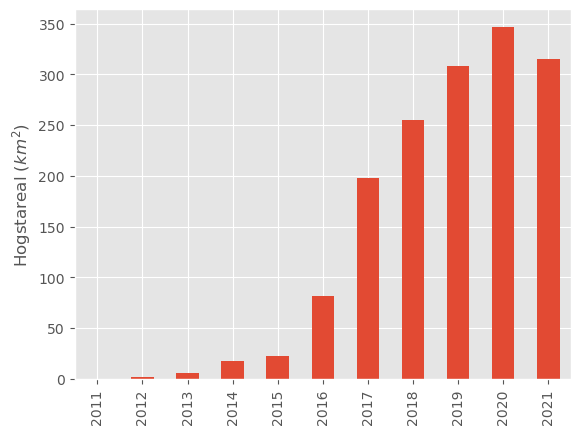

In [11]:
df.set_index('year').plot.bar(legend=False)
plt.xlabel('')
plt.ylabel("Hogstareal ($km^2$)")
plt.savefig(r"./images/harvest_area_oslofjord.png", dpi=200, bbox_inches="tight")